## Baffin Bay renewal for Cara

Check whether I see intermediate water renewal in Baffin Bay in 2019.

In [1]:
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import cmocean
import glob
import netCDF4 as nc
import pickle
import gsw

%matplotlib inline

In [2]:
folder     = '/data/brogalla/ANHA12/'
files_2015 = np.sort(glob.glob(folder+'ANHA12-EXH006_5d_gridT_y2015*'))
files_2016 = np.sort(glob.glob(folder+'ANHA12-EXH006_5d_gridT_y2016*'))
files_2017 = np.sort(glob.glob(folder+'ANHA12-EXH006_5d_gridT_y2017*'))
files_2018 = np.sort(glob.glob(folder+'ANHA12-EXH006_5d_gridT_y2018*'))
files_2019 = np.sort(glob.glob(folder+'ANHA12-EXH006_5d_gridT_y2019*'))

In [3]:
file = nc.Dataset(files_2018[0])
T = np.array(file.variables['votemper'])[0,:,:,:]
mesh_lon = np.array(file.variables['nav_lon'])[:,:]
mesh_lat = np.array(file.variables['nav_lat'])[:,:]
depth = np.array(file.variables['deptht'])

Find nearest model point to stations at BB2 (72.75N, -67.00W) and 224 (70.43N, -62.96W)

In [4]:
BB2_lon , BB2_lat  = -67.00, 72.75
B224_lon, B224_lat = -62.96, 70.43

In [5]:
def find_closest_model_point(lon, lat, model_lons, model_lats, grid='NEMO', land_mask=None,
                                tols={'NEMO': {'tol_lon': 0.104, 'tol_lat': 0.0388},
                                    'GEM2.5': {'tol_lon': 0.016, 'tol_lat': 0.012}}):

    if grid not in tols:
        raise KeyError(
            'The provided grid type is not in tols. '
            'Use another grid type or add your grid type to tols.')

    # Search for a grid point with longitude and latitude within
    # tolerance of measured location
    j_list, i_list = np.where(
        np.logical_and(
            (np.logical_and(model_lons > lon - tols[grid]['tol_lon'],
                            model_lons < lon + tols[grid]['tol_lon'])),
            (np.logical_and(model_lats > lat - tols[grid]['tol_lat'],
                            model_lats < lat + tols[grid]['tol_lat']))
        )
    )

    if len(j_list) == 0:
        # If including points outside of domain:
        return np.nan, np.nan
    try:
        j, i = map(np.asscalar, (j_list, i_list))
    except ValueError:
        # Several points within tolerance
        # Calculate distances for all and choose the closest
        lons = [model_lons[j_list[n], i_list[n]] for n in range(len(j_list))]
        lats = [model_lats[j_list[n], i_list[n]] for n in range(len(j_list))]
        dists = haversine(
            np.array([lon] * i_list.size), np.array([lat] * j_list.size),
            lons, lats)
        n = dists.argmin()
        j, i = map(np.asscalar, (j_list[n], i_list[n]))

    # If point is on land and land mask is provided
    # try to find closest water point
    if land_mask is None or not land_mask[j, i]:
        return j, i
    try:
        return _spiral_search_for_closest_water_point(
            j, i, land_mask, lon, lat, model_lons, model_lats)
    except ValueError:
        raise ValueError(
            'lat/lon on land and no nearby water point found')


def haversine(lon1, lat1, lon2, lat2):
    """Calculate the great-circle distance in kilometers between two points
    on a sphere from their longitudes and latitudes.

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [6]:
def profile_BB(files_year):
    T_BB2 = np.empty((len(files_year), 50))
    T_224 = np.empty((len(files_year), 50))
    i=0
    for file in files_year:
        f = nc.Dataset(file)
        T_BB2[i,:] = np.array(f.variables['votemper'])[0,:,BB2_indx,BB2_indy]
        T_224[i,:] = np.array(f.variables['votemper'])[0,:,B224_indx,B224_indy]
        i+=1
        
    return T_BB2, T_224

In [7]:
def plot_profiles(i):
    fig, ax = plt.subplots(1,2, figsize=(8,6))

    ax[0].plot(T_BB2_2015[i,:], depth, '-', linewidth=2.0, c='#038db2')
    ax[0].plot(T_BB2_2017[i,:], depth, '-', linewidth=2.0, c='#40c0a6')
    ax[0].plot(T_BB2_2019[i,:], depth, '-', linewidth=3.5, c='k')
    ax[0].plot(T_224_2019[i,:], depth, '-', linewidth=2.0, c='#c9bccd')
    ax[0].set_title(files_2018[i][50:-3]+', modelled')

    ax[0].invert_yaxis()
    ax[0].set_ylim(2500,0)
    ax[0].set_xlim(-2,2.5)
    ax[0].set_xlabel('Temperature [C]')
    ax[0].set_ylabel('Depth [m]')

    ax[1].plot(T_BB2_2015[i,:], depth, '-', linewidth=2.0, c='#038db2', label='BB2 2015')
    ax[1].plot(T_BB2_2017[i,:], depth, '-', linewidth=2.0, c='#40c0a6', label='BB2 2017')
    ax[1].plot(T_BB2_2019[i,:], depth, '-', linewidth=3.5, c='k', label='BB2 2019')
    ax[1].plot(T_224_2019[i,:], depth, '-', linewidth=2.0, c='#c9bccd', label='stn224 2019')
    ax[1].set_title(files_2018[i][50:-3]+', modelled zoom')

    ax[1].invert_yaxis()
    ax[1].set_ylim(500,0)
    ax[1].set_xlim(-2,6)
    ax[1].set_xlabel('Temperature [C]')
    ax[1].set_ylabel('Depth [m]')
    ax[1].legend(loc=(0.5, 0.01), frameon=False)
    return

In [19]:
def hovmoeller(variable, depth_range, title=''):
    depth_min, depth_max = depth_range
    fig, ax = plt.subplots(1,1, figsize=(10,4))

    # Plot temperature contours
    CB = ax.contourf(dates_list, depth, np.transpose(variable), levels=np.linspace(-2,4,13), vmin=-2, vmax=4)
    ax.contour(dates_list, depth, np.transpose(variable), colors='w', linewidths=0.5, levels=np.linspace(-2,4,7), vmin=-2, vmax=4)

    ax.axvline(x=dt.datetime(2015,8,1), linestyle='-', linewidth=2.0, c='w')
    ax.axvline(x=dt.datetime(2016,8,1), linestyle='-', linewidth=2.0, c='w')
    ax.axvline(x=dt.datetime(2017,8,1), linestyle='-', linewidth=2.0, c='w')
    ax.axvline(x=dt.datetime(2018,8,1), linestyle='-', linewidth=2.0, c='w')
    ax.axvline(x=dt.datetime(2019,8,1), linestyle='-', linewidth=2.0, c='w')

    # Colorbar:
    cbar_ax = fig.add_axes([0.91, 0.35, 0.02, 0.52])
    cbar    = fig.colorbar(CB, cax=cbar_ax, ticks=[-2, -1, 0, 1, 2, 3, 4])
    cbar.set_label('Potential Temperature')

    # Settings
    ax.set_title(title)
    ax.invert_yaxis()
    ax.set_xlabel('Date')
    ax.set_ylabel('Depth [m]')
    ax.set_ylim(depth_max,depth_min)
    
    fig.savefig('/ocean/brogalla/GEOTRACES/figures/Cara-'+title+'.png', bbox_inches='tight')
    
    return

In [9]:
BB2_indx , BB2_indy  = find_closest_model_point(BB2_lon, BB2_lat, mesh_lon, mesh_lat)
B224_indx, B224_indy = find_closest_model_point(B224_lon, B224_lat, mesh_lon, mesh_lat)

/home/brogalla/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
/home/brogalla/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


Look at temperature profiles for Baffin Bay:

In [10]:
T_BB2_2015, T_BB2_2016, T_BB2_2017, \
    T_BB2_2018, T_BB2_2019 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/T_BB2.pickle','rb'))

T_224_2015, T_224_2016, T_224_2017, \
    T_224_2018, T_224_2019 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/T_224.pickle','rb'))

In [11]:
S_BB2_2015, S_BB2_2016, S_BB2_2017, \
    S_BB2_2018, S_BB2_2019 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/S_BB2.pickle','rb'))

S_224_2015, S_224_2016, S_224_2017, \
    S_224_2018, S_224_2019 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/S_224.pickle','rb'))

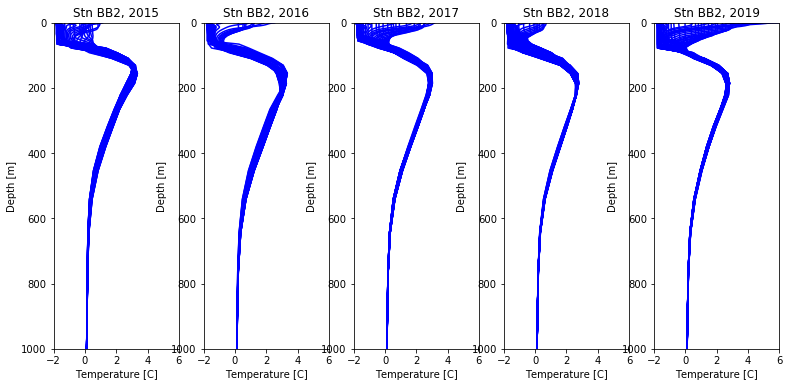

In [39]:
fig, ax = plt.subplots(1,5, figsize=(13,6))

for i in range(0,len(T_BB2_2015)):
    ax[0].plot(T_BB2_2015[i,:], depth,'-b')
    ax[0].set_title('Stn BB2, 2015')

for i in range(0,len(T_BB2_2016)):
    ax[1].plot(T_BB2_2016[i,:], depth,'-b')
    ax[1].set_title('Stn BB2, 2016')
    
for i in range(0,len(T_BB2_2017)):
    ax[2].plot(T_BB2_2017[i,:], depth,'-b')
    ax[2].set_title('Stn BB2, 2017')

for i in range(0,len(T_BB2_2018)):
    ax[3].plot(T_BB2_2018[i,:], depth,'-b')
    ax[3].set_title('Stn BB2, 2018')

for i in range(0,len(T_BB2_2019)):
    ax[4].plot(T_BB2_2019[i,:], depth,'-b')
    ax[4].set_title('Stn BB2, 2019')

for axes in ax:
    axes.invert_yaxis()
    axes.set_ylim(1000,0)
    axes.set_xlim(-2,6)
    axes.set_xlabel('Temperature [C]')
    axes.set_ylabel('Depth [m]')

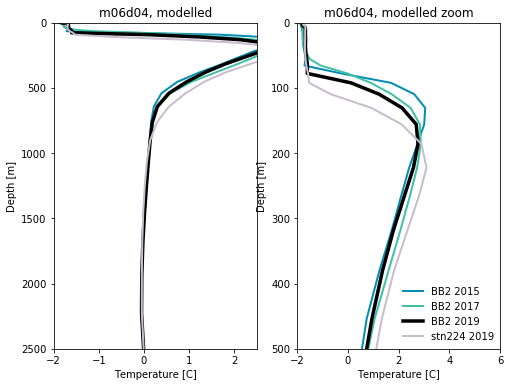

In [19]:
plot_profiles(30)

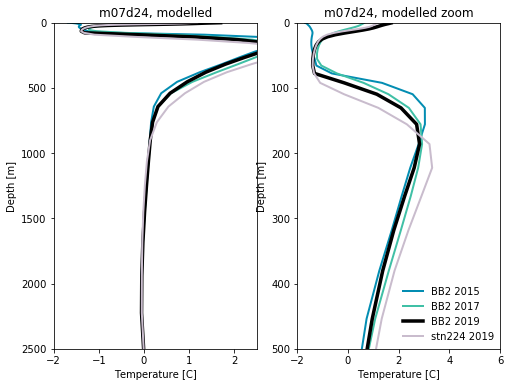

In [17]:
plot_profiles(40)

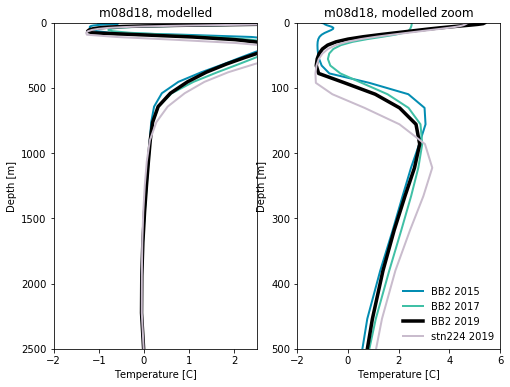

In [18]:
plot_profiles(45)

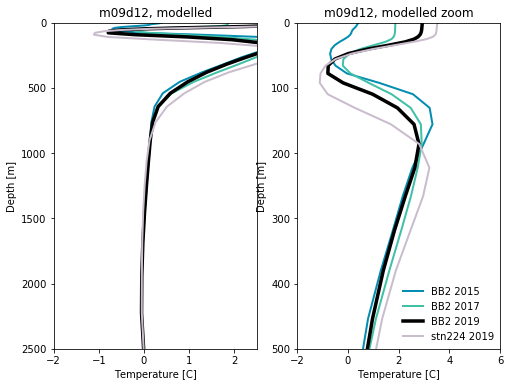

In [16]:
plot_profiles(50)

##### Hovmoeller Plot

In [13]:
T_BB2 = np.stack((T_BB2_2015, T_BB2_2016, T_BB2_2017, T_BB2_2018, T_BB2_2019)).reshape((73*5, 50))
T_224 = np.stack((T_224_2015, T_224_2016, T_224_2017, T_224_2018, T_224_2019)).reshape((73*5, 50))

In [14]:
S_BB2 = np.stack((S_BB2_2015, S_BB2_2016, S_BB2_2017, S_BB2_2018, S_BB2_2019)).reshape((73*5, 50))
S_224 = np.stack((S_224_2015, S_224_2016, S_224_2017, S_224_2018, S_224_2019)).reshape((73*5, 50))

In [15]:
PT_BB2 = gsw.conversions.pt_from_CT(S_BB2, T_BB2)
PT_224 = gsw.conversions.pt_from_CT(S_224, T_224)

In [16]:
dates_names_2015 = [file[46:-3] for file in files_2015]
dates_names_2016 = [file[46:-3] for file in files_2016]
dates_names_2017 = [file[46:-3] for file in files_2017]
dates_names_2018 = [file[46:-3] for file in files_2018]
dates_names_2019 = [file[46:-3] for file in files_2019]
dates_names = dates_names_2015+dates_names_2016+dates_names_2017+dates_names_2018+dates_names_2019

dates_list = np.array([dt.datetime.strptime(date, '%Ym%md%d').date() for date in dates_names])

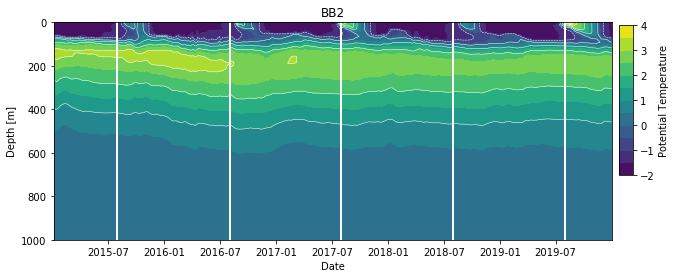

In [20]:
hovmoeller(PT_BB2, (0, 1000), title='BB2')

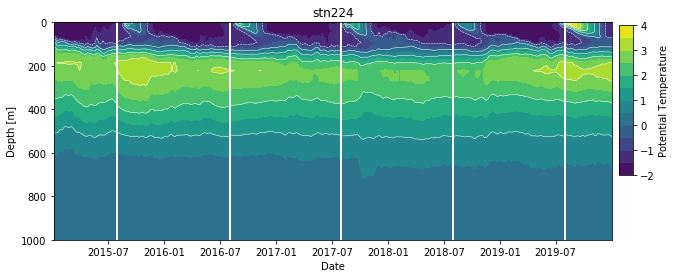

In [21]:
hovmoeller(PT_224, (0, 1000), title='stn224')

##### Old:

In [82]:
T_BB2_2015, T_224_2015 = profile_BB(files_2015)
T_BB2_2016, T_224_2016 = profile_BB(files_2016)
T_BB2_2017, T_224_2017 = profile_BB(files_2017)
T_BB2_2018, T_224_2018 = profile_BB(files_2018)
T_BB2_2019, T_224_2019 = profile_BB(files_2019)

In [83]:
pickle.dump((T_BB2_2015, T_BB2_2016, T_BB2_2017, T_BB2_2018, T_BB2_2019),\
            open('/ocean/brogalla/GEOTRACES/pickles/T_BB2.pickle','wb'))

pickle.dump((T_224_2015, T_224_2016, T_224_2017, T_224_2018, T_224_2019),\
            open('/ocean/brogalla/GEOTRACES/pickles/T_224.pickle','wb'))

In [8]:
S_BB2_2015, S_224_2015 = profile_BB(files_2015)
S_BB2_2016, S_224_2016 = profile_BB(files_2016)
S_BB2_2017, S_224_2017 = profile_BB(files_2017)
S_BB2_2018, S_224_2018 = profile_BB(files_2018)
S_BB2_2019, S_224_2019 = profile_BB(files_2019)

In [16]:
pickle.dump((S_BB2_2015, S_BB2_2016, S_BB2_2017, S_BB2_2018, S_BB2_2019),\
            open('/ocean/brogalla/GEOTRACES/pickles/S_BB2.pickle','wb'))

pickle.dump((S_224_2015, S_224_2016, S_224_2017, S_224_2018, S_224_2019),\
            open('/ocean/brogalla/GEOTRACES/pickles/S_224.pickle','wb'))